# Compare CAT grating positons and orientations derived by Ed and me

Ed Hertz has chosen positions and orientations for CAT grating facets based on the Rowland geometry that we agreed on and that is detailed in http://space.mit.edu/home/guenther/ARCUS/RowlandGeometry.html. Here, I read in the positions and orientations of the CAT gratings from Ed (Casey converted the STEP file into a simple ASCII file that I can read in Python). I take the X and Y postions from that data, and then I calculate the Z positions. I find that the X position that I come up with and that Ed/Casey gave me agrees to numerical position, but the offset between them is systematic. To avoid that biasing the comparison of the orientation of a CAT grating (given by normal vector, grating bar vector and dispersion direction), in the second step, I read the entire X, Y, Z position from the data table and then apply the same formuales that I always do when placing gratings (set normal, set grating direction and rotate by blaze angle). I find that the angle between the vectors in the datafile and the vectors that I calculate is 0 to numerical precision.

In [4]:
from copy import deepcopy

import numpy as np
import astropy.units as u
from marxs.simulator import ParallelCalculated
from arcus.load_csv import load_table2d, load_number, load_table
import transforms3d

from arcus.arcus import defaultconf as conf
from arcus.arcus import CATGrating

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
blazemat = transforms3d.axangles.axangle2mat(np.array([0, 0, 1]),
                                             np.deg2rad(-conf['blazeang']))
blazematm = transforms3d.axangles.axangle2mat(np.array([0, 0, 1]),
                                              np.deg2rad(conf['blazeang']))
gratinggrid = {'z_range': [1e4, 1.4e4],
               'elem_class': CATGrating,
               'elem_args': {'d': 2e-4, 'zoom': [1., 13.5, 13.],
                             'orientation': blazemat,
                             'order_selector': None},
               'parallel_spec': np.array([1., 0., 0., 0.])
}

gratinggrid['elem_args']['orientation'] = blazematm
gratinggrid['normal_spec'] = np.array([0., 0., 0., 1.])

## Compare Z position

The point of defining this class here as opposed to using the version
from arcus.ralfgrating is that this check still works when that class
has been modified, e.g. it coudl just take all numbers from
the input table and just derive from Parallel without any
calculated. That would mean that the checks below won't work any longer.

In [9]:
class XYfromMechanical(ParallelCalculated):
    def __init__(self, **kwargs):
        self.data = load_table('gratings', 'facets')
        self.z_range = kwargs.pop('z_range')
        self.rowland = kwargs.pop('rowland')
        kwargs['pos_spec'] = self.elempos
        kwargs['elem_args']['d'] = list(self.data['period'])

        kwargs['elem_args']['zoom'] = [[1, row['xsize'] / 2, row['ysize'] / 2] for row in self.data]
        super(XYfromMechanical, self).__init__(**kwargs)

    def elempos(self):

        zpos = []
        for x, y in zip(self.data['X'].data, self.data['Y'].data):
            zpos.append(self.rowland.solve_quartic(x=x, y=y, interval=self.z_range))

        return np.vstack([self.data['X'].data,
                          self.data['Y'].data,
                          np.array(zpos),
                          np.ones_like(zpos)]).T

In [22]:
c = XYfromMechanical(rowland=conf['rowland_central_m'], pos4d=conf['shift_optical_axis_1'], **gratinggrid)
e = np.stack(c.elem_pos)

INFO:root:Loading data from gratings/facets


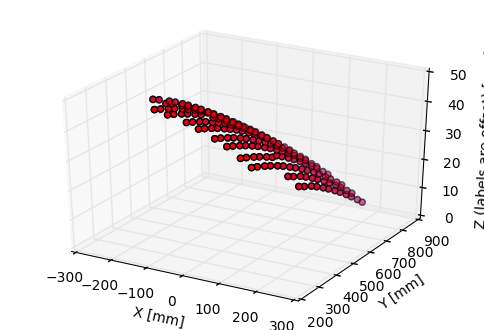

In [23]:
# 3D plot of xyz position

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter3D(c.data['X'], c.data['Y'], c.data['Z'], c='b')
ax.scatter3D(e[:, 0, 3], e[:, 1, 3], e[:, 2, 3], c='r')
ax.set_zlabel('Z (labels are offset) [mm]')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')

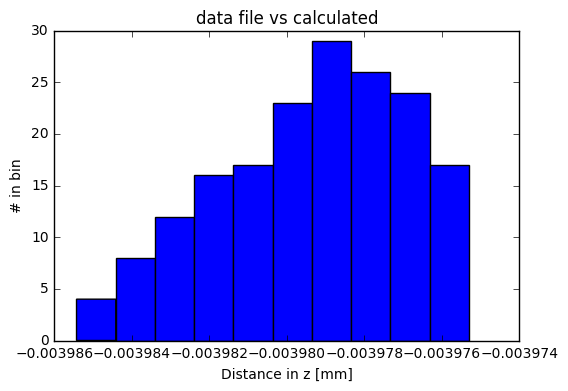

In [24]:
plt.hist(c.data['Z'] - e[:, 2, 3])
plt.title('data file vs calculated')
plt.xlabel('Distance in z [mm]')
plt.ylabel('# in bin')

So, what I did was this:

Read in the X, Y locations from the file. Then, I calculate the Z position and compare that to the Z position in the file. My values for Z are systematically larger by 0.00398 +-2e-6 mm. Still 0.00398 mm out of 12 m is a relative change of 3.4e-7, so I'm assuming that one of us rounded to floating point precision. (My code should use double precision, but I also see that the vectors that I read from Casey's file are normalized to a precision of about 1e-12, so he used double precision as well. I think 1:1e-7 is about the precision of the radii forthe Rowland torus tha we agreed on, so maybe Ed's using more digits on that internally than he gave me.) 

In summay, what I see here is good enough for me, although I know you like to get everything the same to ridiculous precision.

## Compare orientation

To compare the orientation vectors (normal, direction of grating bars, and dispersion direction), I buidl the cross product between the vectors I read fomr the data file and those that I calculate. Since both vectors are normalized, the cross product shoudl be exactly 1. The differences that I find are of order $10^{-13}$ and are symmetric around 1; showing tha we agree to numerical precision.

In [25]:
class XYZfromMechanical(XYfromMechanical):
     def elempos(self):
        return np.vstack([self.data['X'].data,
                          self.data['Y'].data,
                          self.data['Z'].data,
                          np.ones(len(self.data))]).T

In [55]:
c = XYZfromMechanical(rowland=conf['rowland_central_m'], pos4d=conf['shift_optical_axis_1'], **gratinggrid)
pos = np.stack([e.pos4d for e in c.elements])

INFO:root:Loading data from gratings/facets


In [27]:
def vec(data, name):
    return np.stack([data[name + 'X'], data[name + 'Y'], data[name + 'Z']])

In [32]:
norm = vec(c.data, 'NormN')
gbar = vec(c.data, 'GBarN')
disp = vec(c.data, 'DispN')

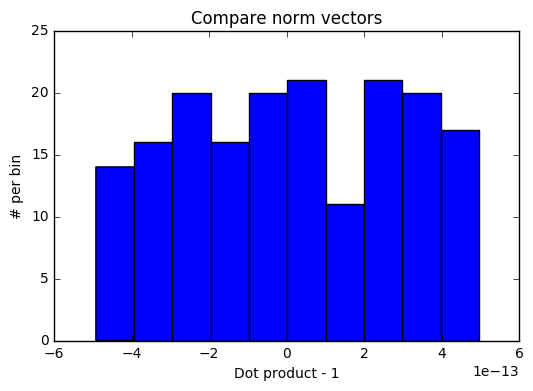

In [64]:
out = plt.hist((norm.T * pos[:, :3, 0]).sum(axis=1) - 1)
plt.ylabel('# per bin')
plt.xlabel('Dot product - 1')
plt.title('Compare norm vectors')

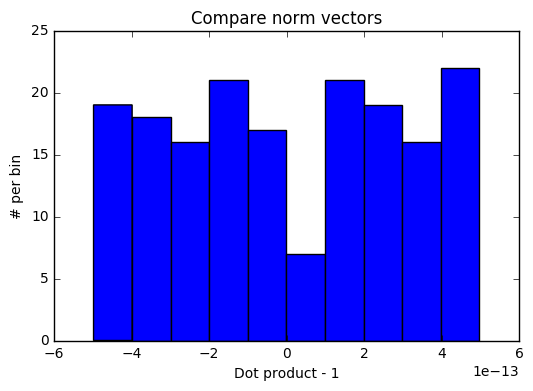

In [88]:
out = plt.hist((gbar.T * pos[:, :3, 2]).sum(axis=1) / np.linalg.norm(pos[:, :3, 2], axis=1)-1)
plt.ylabel('# per bin')
plt.xlabel('Dot product - 1')
plt.title('Compare GBar vectors')

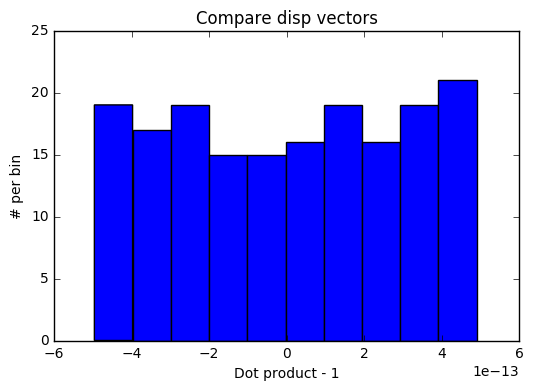

In [89]:
out = plt.hist((disp.T * pos[:, :3, 1]).sum(axis=1) / np.linalg.norm(pos[:, :3, 1], axis=1)-1)
plt.ylabel('# per bin')
plt.xlabel('Dot product - 1')
plt.title('Compare disp vectors')

In [90]:
from nbtemplate import display_codetoggle
display_codetoggle()